# Load Packages, Libraries and Configs

* load packages

In [1]:
from RES.hdf5_handler import DataHandler
import RES.visuals as vis
import RES.utility as utils
import pandas as pd
import geopandas as gpd
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

* Load Config

In [2]:

cfg=utils.load_config('config/config_WB6.yaml')

utils.print_banner("WB6 Supported Regions")
print(">> Country Code: name <<\n")
for keys in cfg.get('region_mapping'):
    print(f"{keys}: {cfg.get('region_mapping').get(keys).get('name')}")


*********************
WB6 Supported Regions
*********************
>> Country Code: name <<

AL: Albania
BA: Bosnia and Herzegovina
XK: Kosovo
ME: Montenegro
MK: North Macedonia
RS: Serbia


# Set Country

In [42]:
# The tool is designed to work for WB6 regions
country_code='AL'
country_name=cfg.get('region_mapping').get(country_code).get('name')

### Load store (hdf5 file)

In [43]:

store=f"./data/store/resources_{country_code}.h5" 
res_data=DataHandler(store) # the DataHandler object could be initiated without the store definition as well.
res_data.show_tree(store)
utils.print_banner(f"Store loaded for {country_name} ({country_code})")

____________________________________________________________
     Structure of HDF5 file: ./data/store/resources_AL.h5
____________________________________________________________
[key] boundary
[key] cells
[key] clusters
  └─ [key] clusters/solar
  └─ [key] clusters/wind
[key] cost
  └─ [key] cost/atb
  └─   └─ [key] cost/atb/solar
  └─   └─ [key] cost/atb/wind
[key] dissolved_indices
  └─ [key] dissolved_indices/solar
  └─ [key] dissolved_indices/wind
[key] lines
[key] timeseries
  └─ [key] timeseries/clusters
  └─   └─ [key] timeseries/clusters/solar
  └─   └─ [key] timeseries/clusters/wind
  └─ [key] timeseries/solar
  └─ [key] timeseries/wind
[key] units


└> To access the data : 
 └> <datahandler instance>.from_store('<key>')
*****************************
Store loaded for Albania (AL)
*****************************


### Load dataframes from Store

In [44]:
# Loading dataframes
cells=res_data.from_store('cells')
boundary=res_data.from_store('boundary')
lines=res_data.from_store('lines')
ss=res_data.from_store('substations')
timeseries_clusters_solar=res_data.from_store('timeseries/clusters/solar')
timeseries_clusters_wind=res_data.from_store('timeseries/clusters/wind')
clusters_solar=res_data.from_store('clusters/solar')
clusters_wind=res_data.from_store('clusters/wind')

Error: Key 'substations' not found in data/store/resources_AL.h5


# Create Visuals

## Grid

In [45]:
# for columns in lines.columns:
#     print(f"{columns}")

### lines

/tmp/ipykernel_2482258/4198720137.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Dark2', len(voltages_kv))  # tab20 has 20 distinct colors


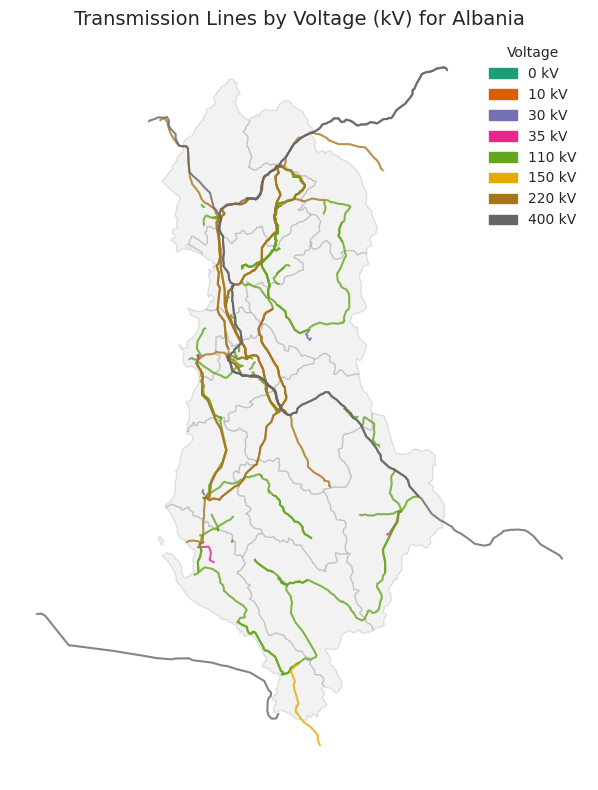

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 8))
boundary.plot(ax=ax, facecolor='grey', edgecolor='black', linewidth=1, alpha=0.1)

if 'voltage' in lines.columns:
    # Convert to numeric and drop NaNs
    voltages = pd.to_numeric(lines['voltage'], errors='coerce').dropna().unique()
    voltages.sort()
    
    # Convert to kilovolts (kV)
    voltages_kv = voltages / 1000

    # Use a qualitative color map with enough distinct colors
    cmap = plt.cm.get_cmap('Dark2', len(voltages_kv))  # tab20 has 20 distinct colors

    color_map = {v_orig: cmap(i) for i, v_orig in enumerate(voltages)}

    # Plot each voltage level with its unique color
    for v_orig in voltages:
        color = color_map[v_orig]
        mask = pd.to_numeric(lines['voltage'], errors='coerce') == v_orig
        lines[mask].plot(ax=ax, color=color, linewidth=1.5, alpha=0.8)

    # Create legend patches
    legend_patches = [
        mpatches.Patch(color=color_map[v], label=f"{int(v / 1000)} kV") for v in voltages
    ]
    ax.legend(handles=legend_patches, title='Voltage', frameon=False)
    ax.set_title(f'Transmission Lines by Voltage (kV) for {country_name}', fontsize=14)

else:
    lines.plot(ax=ax, color='blue', linewidth=1)
    ax.set_title('Transmission Lines', fontsize=14)

ax.set_axis_off()
plt.tight_layout()

plt.savefig(f"vis/network/transmission_lines_{country_code}.png", bbox_inches='tight', dpi=300)
plt.show()

### Substations

In [47]:
# <code>

## Resources

### Capacity Factor Map

In [48]:
def get_CF_map_plot(cells, 
                    resource_type='solar', 
                    title:str=None,
                    ax=None, 
                    show=True):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))  # fallback if no ax passed
    else:
        fig = ax.figure

    cmap = 'YlOrRd' if resource_type == 'solar' else 'BuPu'
    column = f"{resource_type}_CF_mean"
    vmin = cells[column].min()
    vmax = cells[column].max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    # Shadow layer
    shadow_offset = 0.013
    cells_shadow = cells.copy()
    cells_shadow['geometry'] = cells_shadow['geometry'].translate(xoff=-shadow_offset, yoff=shadow_offset)
    cells_shadow.plot(column=column, cmap='Greys', ax=ax, edgecolor='white', alpha=1, linewidth=0.1, zorder=1)

    # Main layer
    cells.plot(column=column, cmap=cmap, ax=ax, edgecolor='k', alpha=1, linewidth=0.1, zorder=2)

    # Colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.02)
    cbar.set_label(f'{resource_type.capitalize()} Capacity Factor (annual mean)', fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    # Set font weight for colorbar tick labels
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')

    if title is not None:
        ax.set_title(title, fontsize=14, fontweight='bold', loc='center')
    ax.set_axis_off()
    if resource_type=='solar':
        utils.print_update(level=2,message= f"Please cross check with Solar CF map with GLobal Solar Atlas Data from : https://globalsolaratlas.info/download/{country_name}")

    if show:
        plt.show()
    vis.add_compass_to_plot(ax,size=12,triangle_size=0.016)
    return ax

 └> Please cross check with Solar CF map with GLobal Solar Atlas Data from : https://globalsolaratlas.info/download/Albania


<Axes: title={'center': 'Solar Resources for Albania'}>

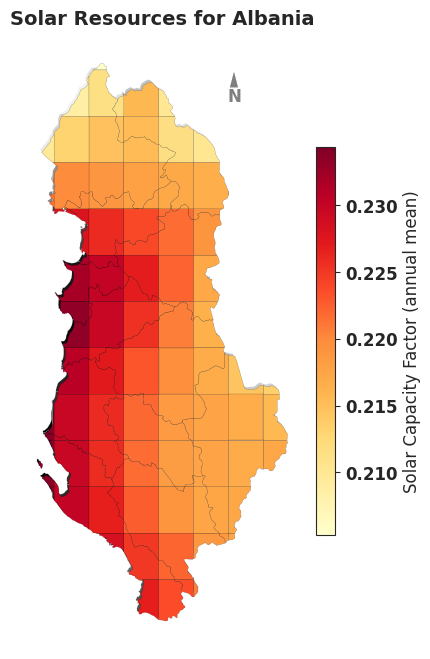

In [49]:
get_CF_map_plot(cells, 
                resource_type='solar', 
                title=f"Solar Resources for {country_name}",
                # ax=ax1, 
                show=False)

 └> Please cross check with Solar CF map with GLobal Solar Atlas Data from : https://globalsolaratlas.info/download/Albania


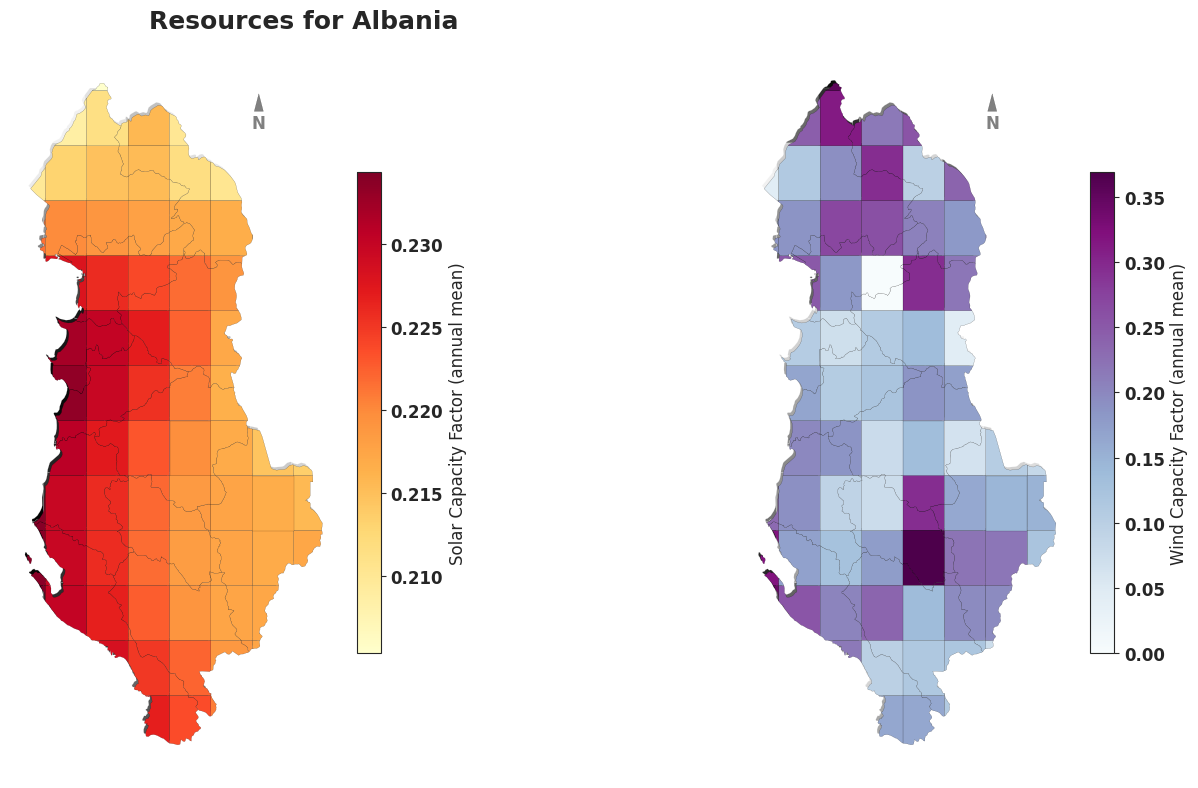

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

fig.suptitle(f"Resources for {country_name}", fontsize=18, fontweight='bold')

get_CF_map_plot(cells, 
                resource_type='solar', 
                ax=ax1, 
                show=False)
get_CF_map_plot(cells, 
                resource_type='wind', 
                ax=ax2, 
                show=False)

plt.tight_layout()

plt.show()


### Capacity

In [51]:
def get_capacity_map_plot(cells:gpd.GeoDataFrame, 
                    resource_type:str, 
                    title:str=None,
                    ax=None, 
                    show=True):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))  # fallback if no ax passed
    else:
        fig = ax.figure

    cmap = 'YlOrRd' if resource_type == 'solar' else 'BuPu'
    column = f"potential_capacity_{resource_type}"
    vmin = cells[column].min()
    vmax = cells[column].max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    # Shadow layer
    shadow_offset = 0.02
    cells_shadow = cells.copy()
    cells_shadow['geometry'] = cells_shadow['geometry'].translate(xoff=-shadow_offset, yoff=shadow_offset)
    cells_shadow.plot(column=column, cmap='Greys', ax=ax, edgecolor='white', alpha=1, linewidth=0.1, zorder=1)

    # Main layer
    cells.plot(column=column, cmap=cmap, ax=ax, edgecolor='k', alpha=1, linewidth=0.1, zorder=2)

    # Colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.02)
    cbar.set_label(f'{resource_type.capitalize()} Potential Capacity (MW)', fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    # Set font weight for colorbar tick labels
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')

    if title is not None:
        ax.set_title(title, fontsize=14, fontweight='bold', loc='center')
    ax.set_axis_off()
    vis.add_compass_to_plot(ax,size=12,triangle_size=0.016)

    if show:
        plt.show()
    
    return ax

<Axes: title={'center': "Solar Resources' Capacity for Albania"}>

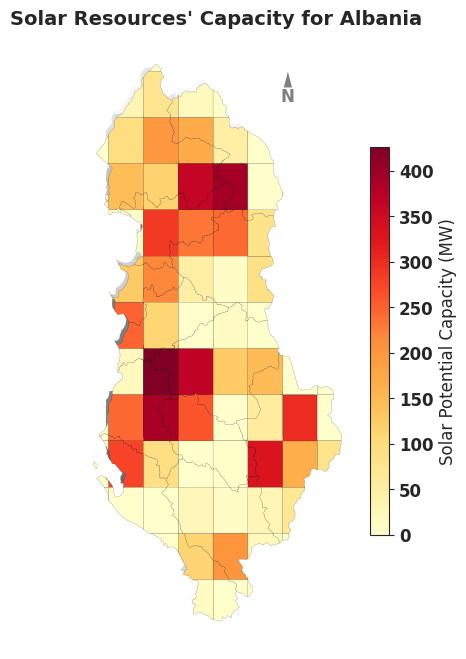

In [52]:
get_capacity_map_plot(cells, 
                resource_type='solar', 
                title=f"Solar Resources' Capacity for {country_name}",
                # ax=ax1, 
                show=False)

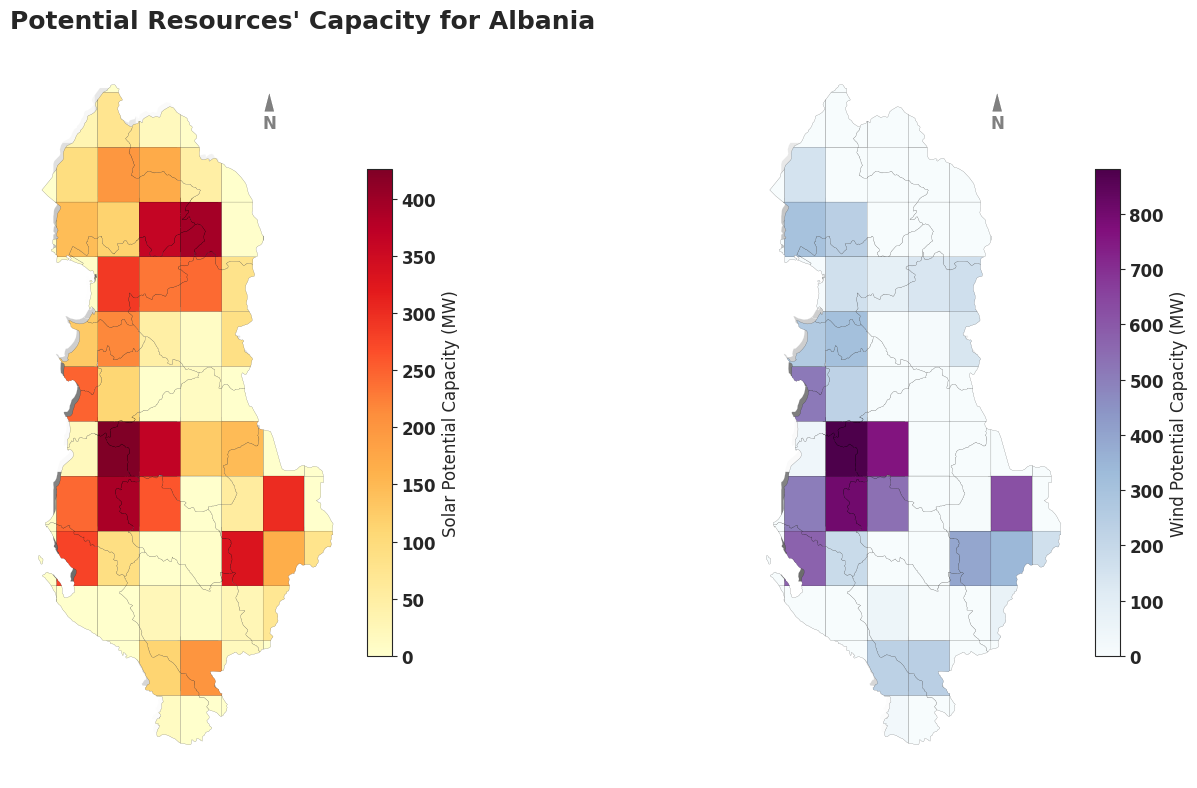

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

fig.suptitle(f"Potential Resources' Capacity for {country_name}", fontsize=18, fontweight='bold')

get_capacity_map_plot(cells, 
                resource_type='solar', 
                ax=ax1, 
                show=False)
get_capacity_map_plot(cells, 
                resource_type='wind', 
                ax=ax2, 
                show=False)

plt.tight_layout()

plt.show()


#### Capacity Plot (bins)

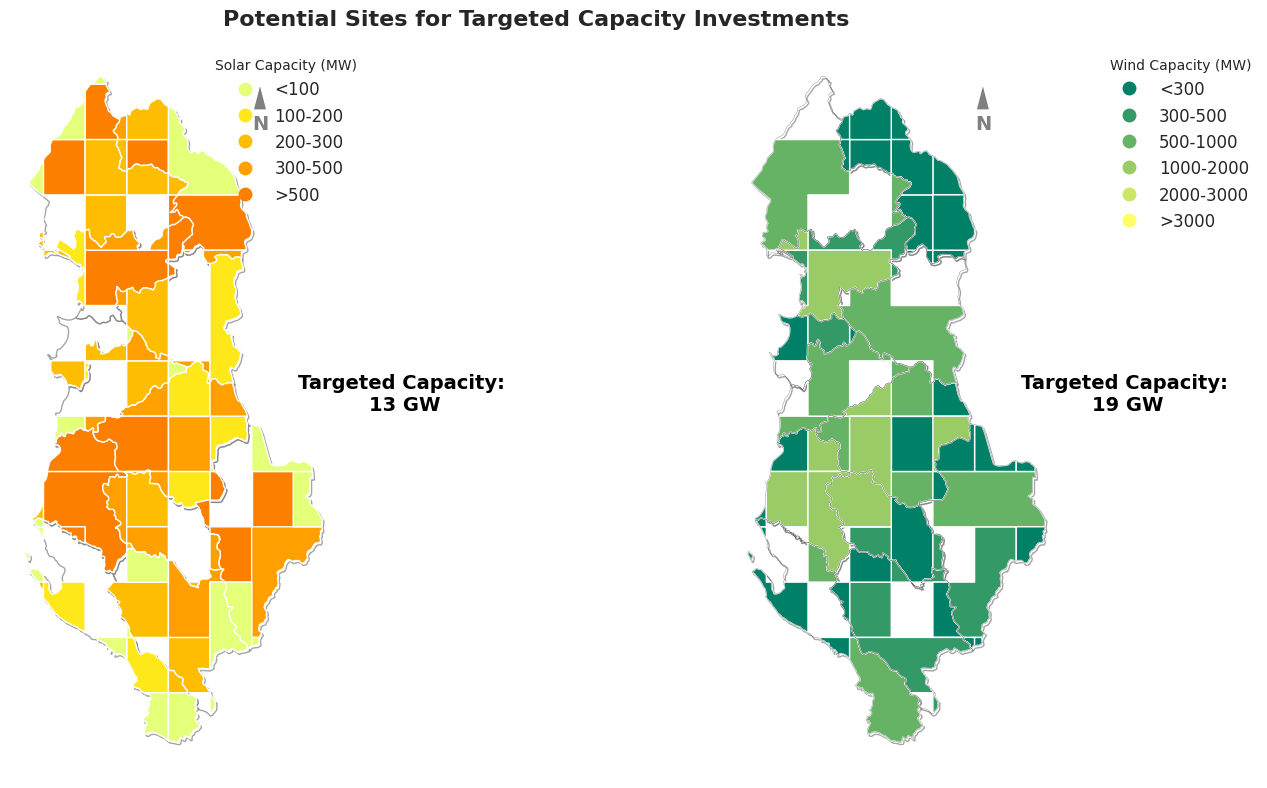

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

legend_x_ax_offset=1.1

# Ensure 'Region' is in the columns for both boundary and cells
# if boundary is not None and ('Region' not in boundary.columns or 'Country' not in boundary.columns):
#     boundary = boundary.reset_index()

# Assign a number to each region
# boundary['Region_Number'] = range(1, len(boundary) + 1)

# Define custom bins and labels for solar and wind capacity
solar_bins = [0, 100, 200, 300, 500, float('inf')]  # Custom ranges
solar_labels = ['<100','100-200', '200-300', '300-500','>500']  # Labels for legend

# Define custom bins and labels for solar and wind capacity
wind_bins = [0, 300, 500, 1000, 2000,3000, float('inf')]  # Custom ranges
wind_labels = ['<300','300-500', '500-1000', '1000-2000','2000-3000', '>3000']  # Labels for legend

# Categorize potential_capacity_solar and potential_capacity_wind into bins
clusters_solar['solar_category'] = pd.cut(clusters_solar['potential_capacity'], bins=solar_bins, labels=solar_labels, include_lowest=True)
clusters_wind['wind_category'] = pd.cut(clusters_wind['potential_capacity'], bins=wind_bins, labels=wind_labels, include_lowest=True)

# Create figure and axes for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16,weight='bold')
# Set axis off for both subplots
ax1.set_axis_off()
ax2.set_axis_off()

# Shadow effect offset
shadow_offset = 0.01

# Plot solar map on ax1
# Add shadow effect for solar map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot solar cells
clusters_solar.plot(column='solar_category', ax=ax1, cmap='Wistia', legend=True, 
           legend_kwds={'title': "Solar Capacity (MW)", 'loc': 'upper right','fontsize':12,'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for solar map
# boundary.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for solar map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=7, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Plot wind map on ax2
# Add shadow effect for wind map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot wind cells
clusters_wind.plot(column='wind_category', ax=ax2, cmap='summer', legend=True, 
           legend_kwds={'title': "Wind Capacity (MW)", 'fontsize':12,'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for wind map
boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for wind map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Adjust layout for cleaner appearance
fig.patch.set_alpha(0)  # Make figure background transparent
plt.tight_layout()


# Add annotation for solar capacity
ax1.annotate(f"Targeted Capacity: \n{int(clusters_solar.potential_capacity.sum()/1e3)} GW",
             xy=(1.2, 0.5), xycoords='axes fraction', ha='center', 
             fontsize=14, color='black', fontweight='bold')

# Add annotation for wind capacity
ax2.annotate(f"Targeted Capacity: \n{int(clusters_wind.potential_capacity.sum()/1e3)} GW",
             xy=(1.2, 0.5), xycoords='axes fraction', ha='center', 
             fontsize=14, color='black', fontweight='bold')
# Show the side-by-side plot

plt.savefig('vis/solar_wind_capacity_map.png',dpi=300)
# Add a directional compass (north arrow) to both subplots
# Use a more standard north arrow style
vis.add_compass_to_plot(ax1)
vis.add_compass_to_plot(ax2)
plt.show()

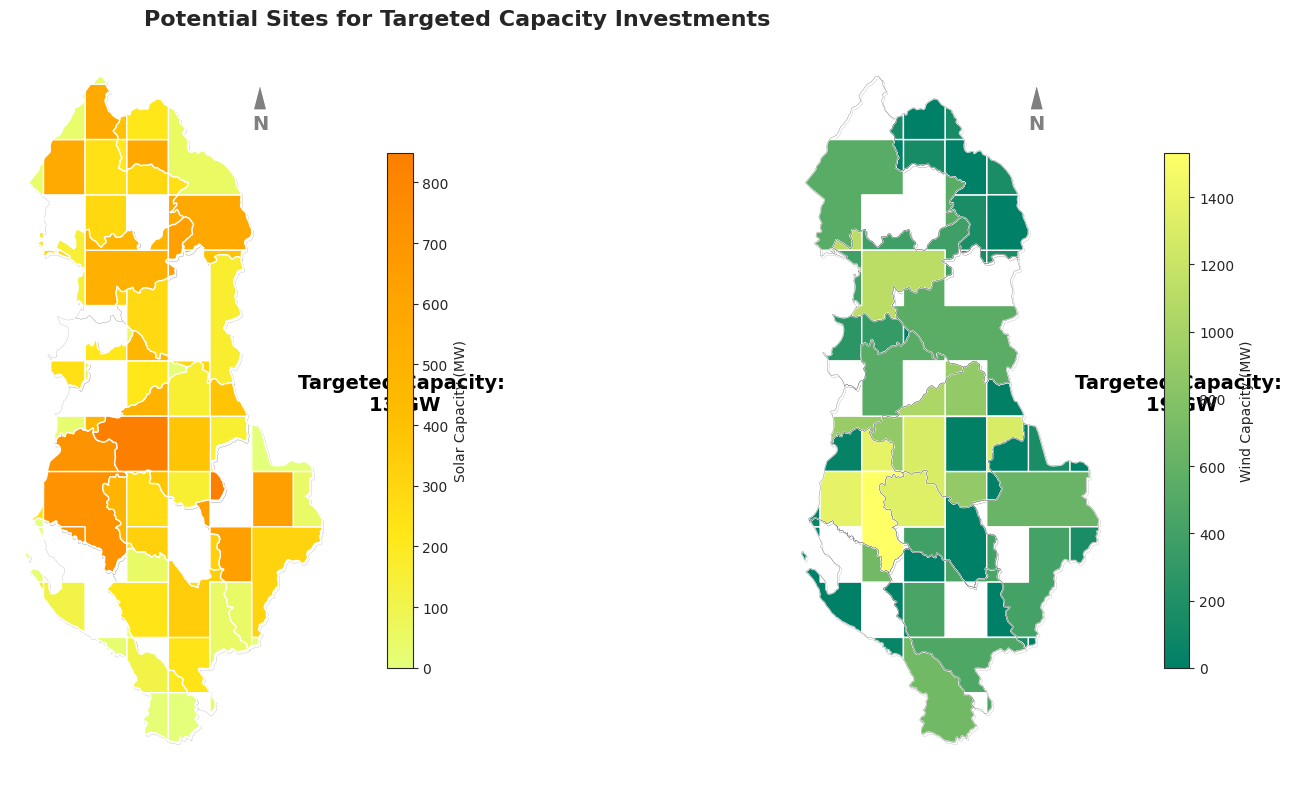

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

legend_x_ax_offset = 1.1
shadow_offset = 0.01

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16, weight='bold')
ax1.set_axis_off()
ax2.set_axis_off()

# --- Solar Map ---
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=0.2, alpha=0.7)
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

clusters_solar.plot(
    column='potential_capacity',
    ax=ax1,
    cmap='Wistia',
    legend=True,
    legend_kwds={'label': "Solar Capacity (MW)", 'shrink': 0.7}  # valid kwargs for colorbar
)


# --- Wind Map ---
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=0.2, alpha=0.7)
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

clusters_wind.plot(
    column='potential_capacity',
    ax=ax2,
    cmap='summer',
    legend=True,
    legend_kwds={'label': "Wind Capacity (MW)", 'shrink': 0.7}
)


boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)

# Add capacity annotations
ax1.annotate(f"Targeted Capacity: \n{int(clusters_solar.potential_capacity.sum()/1e3)} GW",
             xy=(1.2, 0.5), xycoords='axes fraction', ha='center',
             fontsize=14, color='black', fontweight='bold')

ax2.annotate(f"Targeted Capacity: \n{int(clusters_wind.potential_capacity.sum()/1e3)} GW",
             xy=(1.2, 0.5), xycoords='axes fraction', ha='center',
             fontsize=14, color='black', fontweight='bold')

fig.patch.set_alpha(0)
plt.tight_layout()
plt.savefig('vis/solar_wind_capacity_map.png', dpi=300)

# Add compass
vis.add_compass_to_plot(ax1)
vis.add_compass_to_plot(ax2)

plt.show()


└> Combined CF vs LCOE plot created and saved to: vis/Resources_CF_vs_LCOE_combined.png


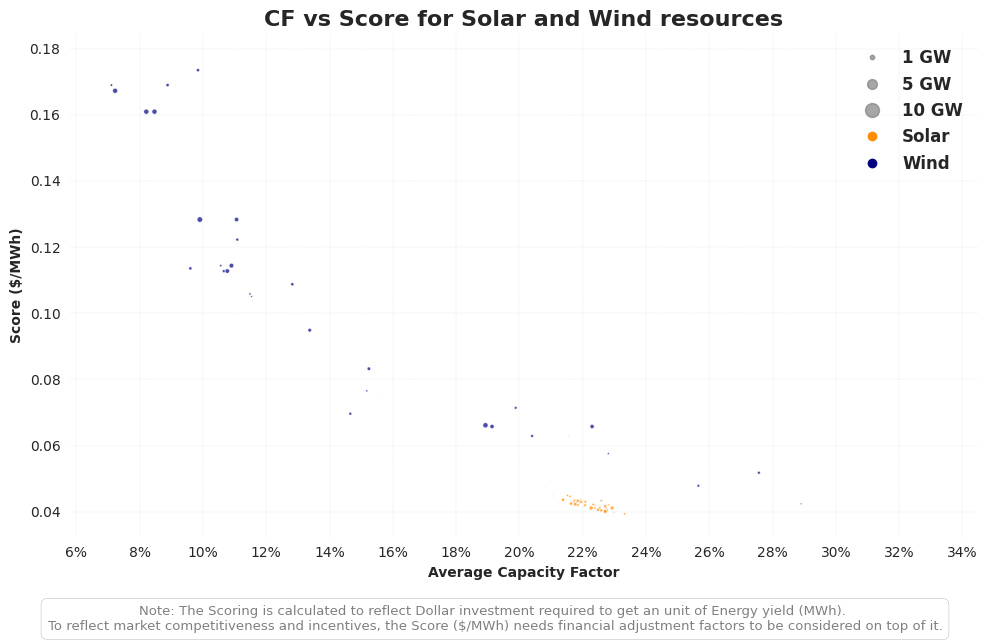

In [56]:
vis.plot_resources_scatter_metric_combined(clusters_solar,clusters_wind,[0.2,0.5,1],0.4)

## CF checks

In [57]:
gwa_country_code=cfg.get('region_mapping').get(country_code).get('GWA_country_code')

### Wind

In [58]:
# Get total bounds from boundary GeoDataFrame
minx, miny, maxx, maxy = boundary.total_bounds

# Create bounding_box_dict with correct keys for downstream use
bounding_box_dict = {
    "minx": float(minx),
    "miny": float(miny),
    "maxx": float(maxx),
    "maxy": float(maxy)
}


In [59]:
import rioxarray as rxr

raster_path=f'./data/downloaded_data/GWA/{gwa_country_code}_capacity-factor_IEC3.tif'
data = (
        rxr.open_rasterio(raster_path)
        .rio.clip_box(**bounding_box_dict)
        .rename('CF_IEC3')
        .drop_vars(['band', 'spatial_ref'])
        .isel(band=1 if '*Class*' in 'CF_IEC3' else 0)  # 'IEC_Class_ExLoads' data is in band 1
    )


In [60]:
gwa_cols = ['CF_IEC2', 'CF_IEC3', 'wind_CF_mean']
cells[gwa_cols].describe().style.format(precision=3).set_caption("Summary Statistics for GWA CF data and calibrated Wind CF_mean")

,CF_IEC2,CF_IEC3,wind_CF_mean
count,134.000,134.000,135.000
mean,0.182,0.204,0.174
std,0.053,0.056,0.080
min,0.060,0.072,0.000
25%,0.145,0.166,0.109
50%,0.178,0.200,0.176
75%,0.212,0.237,0.220
max,0.320,0.347,0.369


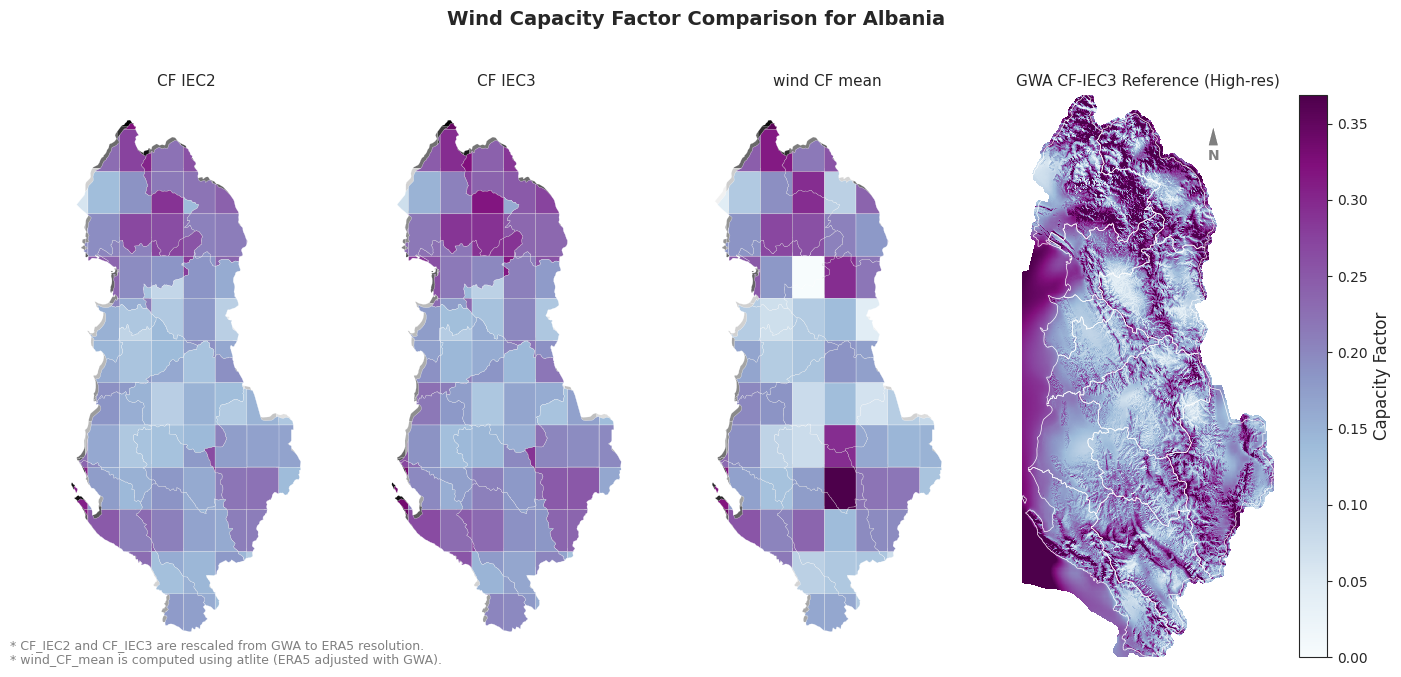

In [61]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Determine common color scale
vmin = cells[gwa_cols].min().min()
vmax = cells[gwa_cols].max().max()

n_maps = len(gwa_cols)
fig, axes = plt.subplots(
    1, n_maps + 1,
    figsize=(3.5 * (n_maps + 1), 6),
    constrained_layout=True
)

# Plot each of the wind CF columns
for ax, col in zip(axes[:-1], gwa_cols):
    # Shadow layer
    shadow_offset = 0.02
    cells_shadow = cells.copy()
    cells_shadow['geometry'] = cells_shadow['geometry'].translate(xoff=-shadow_offset, yoff=shadow_offset)
    cells_shadow.plot(column=col, cmap='Greys', ax=ax, edgecolor='white', alpha=1, linewidth=0.1, zorder=1)
    
    cells.plot(
        column=col,
        ax=ax,
        cmap='BuPu',
        vmin=vmin, vmax=vmax,
        linewidth=0.2,
        legend=False
    )
    ax.set_title(col.replace('_', ' '), fontsize=11)
    ax.axis('off')
    


# Plot the GWA high-res reference
data.plot(ax=axes[-1], cmap='BuPu', vmin=vmin, vmax=vmax,add_colorbar=False)
boundary.plot(ax=axes[-1], facecolor='none', edgecolor='white', linewidth=0.5)
axes[-1].set_title('GWA CF-IEC3 Reference (High-res)', fontsize=11)
axes[-1].axis('off')

# Add a compass before saving
vis.add_compass_to_plot(axes[-1], size=10)

# Unified colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap='BuPu', norm=norm)
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label('Capacity Factor', fontsize=12)

# Suptitle
title_str = f"Wind Capacity Factor Comparison for {country_name}"
plt.suptitle(title_str, fontsize=14, fontweight='bold', y=1.1)

# Footnote / caption
plt.figtext(
    0.01, 0.01,
    "* CF_IEC2 and CF_IEC3 are rescaled from GWA to ERA5 resolution.\n"
    "* wind_CF_mean is computed using atlite (ERA5 adjusted with GWA).",
    ha='left', fontsize=9, color='gray'
)

# Save and show
# plt.savefig('wind_CF_comparison_mean.png', dpi=300, bbox_inches='tight')
plt.show()


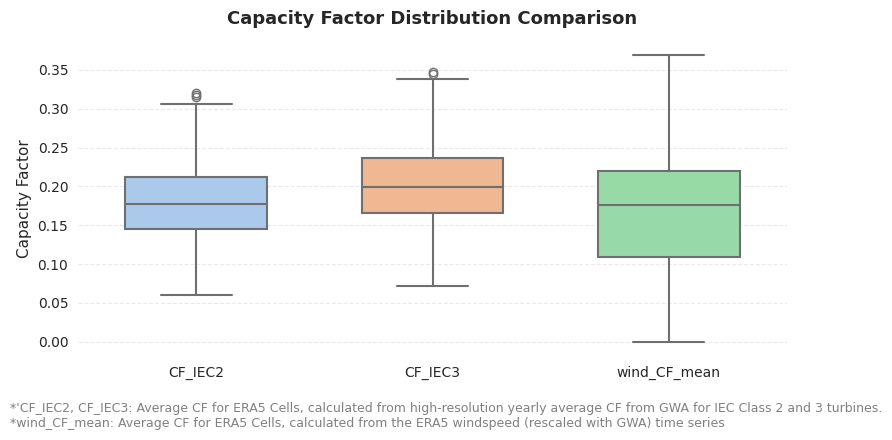

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import fill

# Set a clean and minimal style
sns.set_style("white")

# Initialize the figure
plt.figure(figsize=(8, 4))

# Create the boxplot
ax = sns.boxplot(
    data=cells[['CF_IEC2', 'CF_IEC3', 'wind_CF_mean']],
    palette="pastel",
    linewidth=1.5,
    width=0.6
)

# Set title and labels
ax.set_title('Capacity Factor Distribution Comparison', fontsize=13, weight='semibold', pad=12)
ax.set_ylabel('Capacity Factor', fontsize=11)
ax.set_xlabel('')

# Tweak tick formatting
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.4)
ax.xaxis.grid(False)

plt.figtext(
    0.01, -0.08,
    "*'CF_IEC2, CF_IEC3: Average CF for ERA5 Cells, calculated from high-resolution yearly average CF from GWA for IEC Class 2 and 3 turbines.\n"
    "*wind_CF_mean: Average CF for ERA5 Cells, calculated from the ERA5 windspeed (rescaled with GWA) time series ",
    ha='left', fontsize=9, style='normal', fontweight='normal', color='gray'
)

plt.tight_layout()
plt.show()


### CLusters

In [63]:
clusters_wind_f=clusters_wind[clusters_wind['potential_capacity']>0]
clusters_solar_f=clusters_solar[clusters_solar['potential_capacity']>0]

In [64]:
print(f'Total sites {len(clusters_wind_f)}')
total_capacity=clusters_wind_f.potential_capacity.sum()
print(f'Total Capacity {int(total_capacity/1E3)} GW')
sites=5
top_sites_capacity=clusters_wind_f.head(sites).potential_capacity.sum()
print(f'Top {sites} sites ({round(sites/len(clusters_wind_f)*100)}% site) capacity {int(top_sites_capacity/1E3)} GW ({round(top_sites_capacity/total_capacity*100)}% of total capacity)')

Total sites 33
Total Capacity 19 GW
Top 5 sites (15% site) capacity 1 GW (6% of total capacity)


In [65]:
print(f'Total sites {len(clusters_solar_f)}')
total_capacity=clusters_solar_f.potential_capacity.sum()
print(f'Total Capacity {int(total_capacity/1E3)} GW')
sites=5
top_sites_capacity=clusters_solar_f.head(sites).potential_capacity.sum()
print(f'Top {sites} sites ({round(sites/len(clusters_solar_f)*100)}% site) capacity {int(top_sites_capacity/1E3)} GW ({round(top_sites_capacity/total_capacity*100)}% of total capacity)')

Total sites 46
Total Capacity 13 GW
Top 5 sites (11% site) capacity 2 GW (16% of total capacity)


# Static Plots

In [66]:
aeroway=gpd.read_file(f'./data/downloaded_data/OSM/{country_code}_aeroway.geojson')

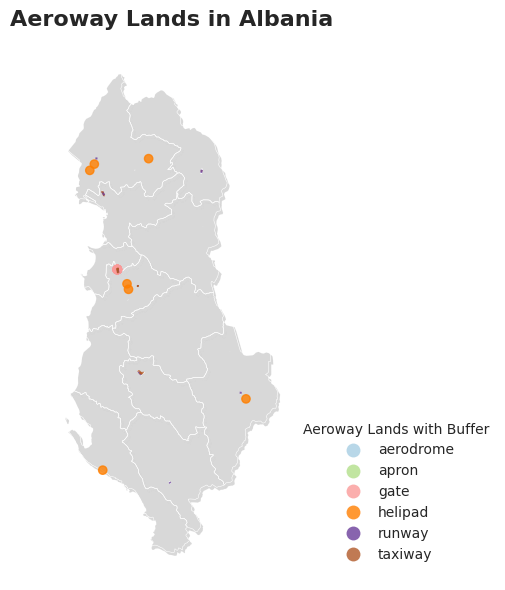

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# Plot boundary with subtle shadow effect
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax, facecolor='grey', edgecolor='lightgray', linewidth=0.2, alpha=0.3)
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)
boundary.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=0.4, alpha=1)

# Plot aeroway data
aeroway.plot(
    column='aeroway',
    ax=ax,
    legend=True,
    legend_kwds={
        'title': "Aeroway Lands with Buffer",
        'loc': 'lower left',
        'bbox_to_anchor': (1, 0.01),
        'frameon': False
    },
    alpha=0.8,
    cmap='Paired'
)

# Clean up plot
ax.set_title(f"Aeroway Lands in {country_name}", fontsize=16, fontweight='bold', pad=15)
ax.axis('off')
plt.tight_layout()
plt.savefig(f'./vis/misc/Aeroway_{country_name}.png', dpi=300)
plt.show()


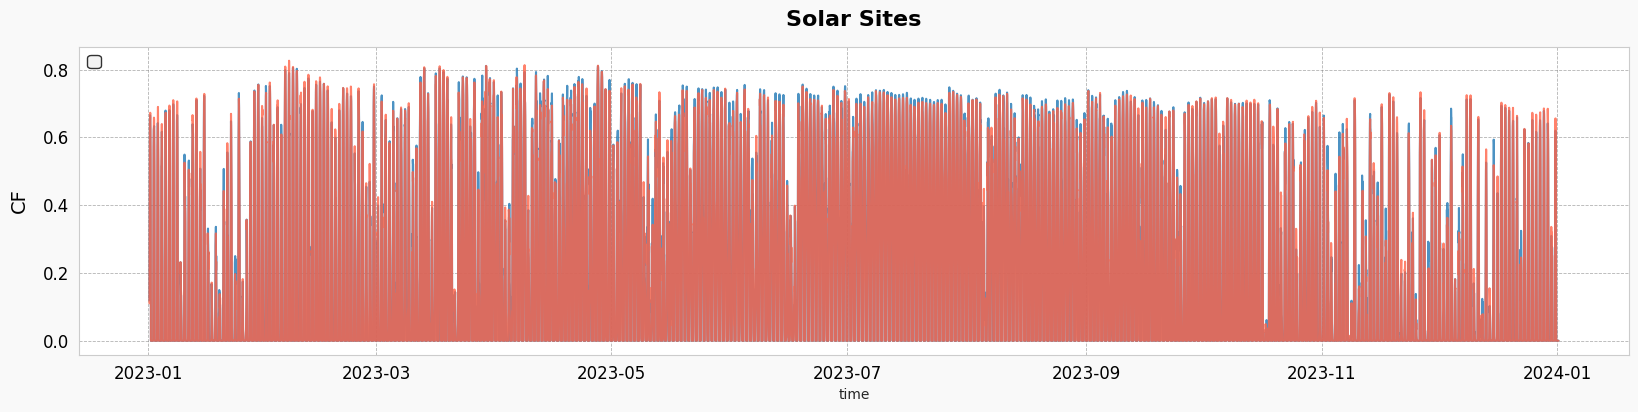

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")  

# Create figure
fig, ax = plt.subplots(figsize=(20, 4), facecolor="#f9f9f9")  # Light background

# Define custom colors
colors = ['#1f77b4', '#ff6347']

# Plot using Seaborn
sns.lineplot(data=timeseries_clusters_solar, x=timeseries_clusters_solar.index, y=timeseries_clusters_solar.iloc[:, 0], ax=ax, color=colors[0], linewidth=1.5, alpha=0.8, )
sns.lineplot(data=timeseries_clusters_solar, x=timeseries_clusters_solar.index, y=timeseries_clusters_solar.iloc[:, 1], ax=ax, color=colors[1], linewidth=1.5, alpha=0.8,)

# Enhance aesthetics
ax.set_facecolor("#ffffff")  # Pure white plot area
ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6, color="gray")

# Labels & title
ax.set_title("Solar Sites", fontsize=16, color="black", fontweight="bold", pad=15)
# ax.set_xlabel("Time", fontsize=14, color="black", labelpad=10)
ax.set_ylabel("CF", fontsize=14, color="black", labelpad=10)

# Customize ticks
ax.tick_params(axis='x', colors="black", labelsize=12)
ax.tick_params(axis='y', colors="black", labelsize=12)

# Add a legend
ax.legend(facecolor="#f0f0f0", edgecolor="black", fontsize=12, loc="upper left", frameon=True)

# Show plot
plt.show()


In [69]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set Seaborn style for better aesthetics
# sns.set_style("whitegrid")  

# # Create figure
# fig, ax = plt.subplots(figsize=(20, 4.5), facecolor="#f9f9f9")  # Light background

# # Define custom colors
# colors = ['#1f77b4', '#ff6347']

# # Plot using Seaborn
# sns.lineplot(data=timeseries_clusters_wind, x=timeseries_clusters_wind.index, y='Capital_1', ax=ax, color=colors[0], linewidth=1.5, alpha=0.8, label="Capital 1")
# sns.lineplot(data=timeseries_clusters_wind, x=timeseries_clusters_wind.index, y='PeaceRiver_1', ax=ax, color=colors[1], linewidth=1.5, alpha=0.8, label="Peace River 1")

# # Enhance aesthetics
# ax.set_facecolor("#ffffff")  # Pure white plot area
# ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6, color="gray")

# # Labels & title
# ax.set_title("Wind Sites", fontsize=16, color="black", fontweight="bold", pad=15)
# # ax.set_xlabel("Time", fontsize=14, color="black", labelpad=10)
# ax.set_ylabel("CF", fontsize=14, color="black", labelpad=10)

# # Customize ticks
# ax.tick_params(axis='x', colors="black", labelsize=12)
# ax.tick_params(axis='y', colors="black", labelsize=12)

# # Add a legend
# ax.legend(facecolor="#f0f0f0", edgecolor="black", fontsize=12, loc="upper left", frameon=True)

# # Show plot
# plt.show()


# Static Data Visuals in Interactive Maps

In [70]:
"""
import hvplot.pandas
import holoviews as hv
from holoviews import opts
from bokeh.layouts import gridplot
from bokeh.io import show

# Initialize Holoviews extension
hv.extension('bokeh')


# Define a dictionary to map columns to specific colormaps
cmap_mapping = {
    'lcoe_wind': 'cool',
    'potential_capacity_wind': 'Blues',
    'lcoe_solar': 'autumn',
    'CF_IEC2': 'RdYlGn',
    'wind_CF_mean': 'RdYlGn',
    'windspeed_ERA5': 'winter',
    'nearest_station_distance_km': 'Oranges',
    'potential_capacity_wind': 'Blues',
    'potential_capacity_solar': 'Oranges',
}

# Define a function to create individual plots
def create_plot(column_name, cmap):
    return cells.hvplot(
        color=column_name,
        cmap=cmap,
        geo=True,
        tiles='CartoDark',  # Default base map
        frame_width=300,  # Adjust the size of the plots
        frame_height=300,  # Adjust the size of the plots
        data_aspect=.5,
        alpha=0.8,
        line_color='None',
        line_width=0.1,
        hover_line_color='red'
    ).opts(title=column_name,
            show_grid=True,
            show_legend=True,
            tools=['hover', 'pan', 'wheel_zoom','reset','box_select'],
            legend_position='top_right'
        )

# Create a list of plots for each column
plots = [create_plot(col, cmap) for col, cmap in cmap_mapping.items()]

# Create a grid layout for the plots
grid = hv.Layout(plots).cols(3)  # Adjust the number of columns as needed

# Show the layout
hv.save(grid, '../docs/grid_plots.html')  # Save the grid layout as an HTML file



# Render the layout as a Bokeh object
bokeh_layout = hv.render(grid, backend='bokeh')

# Show the layout
show(bokeh_layout)
"""

"\nimport hvplot.pandas\nimport holoviews as hv\nfrom holoviews import opts\nfrom bokeh.layouts import gridplot\nfrom bokeh.io import show\n\n# Initialize Holoviews extension\nhv.extension('bokeh')\n\n\n# Define a dictionary to map columns to specific colormaps\ncmap_mapping = {\n    'lcoe_wind': 'cool',\n    'potential_capacity_wind': 'Blues',\n    'lcoe_solar': 'autumn',\n    'CF_IEC2': 'RdYlGn',\n    'wind_CF_mean': 'RdYlGn',\n    'windspeed_ERA5': 'winter',\n    'nearest_station_distance_km': 'Oranges',\n    'potential_capacity_wind': 'Blues',\n    'potential_capacity_solar': 'Oranges',\n}\n\n# Define a function to create individual plots\ndef create_plot(column_name, cmap):\n    return cells.hvplot(\n        color=column_name,\n        cmap=cmap,\n        geo=True,\n        tiles='CartoDark',  # Default base map\n        frame_width=300,  # Adjust the size of the plots\n        frame_height=300,  # Adjust the size of the plots\n        data_aspect=.5,\n        alpha=0.8,\n        

# Timeseries Plots

In [71]:
# import pandas as pd
# import hvplot.pandas
# import panel as pn
# import random

# # Initialize Panel with the dark theme
# pn.extension(theme='default')

# # Load your DataFrames
# df_solar = timeseries_clusters_solar  # Your solar DataFrame
# df_wind = timeseries_clusters_wind    # Your wind DataFrame

# # Create a list of the column names for the dropdowns
# solar_options = df_solar.columns.tolist()
# wind_options = df_wind.columns.tolist()

# # Function to generate a random vibrant color
# def get_random_vibrant_color():
#     return "#{:02x}{:02x}{:02x}".format(random.randint(150, 255), random.randint(150, 255), random.randint(150, 255))


# # Create a function to update the solar plot based on the selected time series
# def update_solar_plot(selected_series):
#     return df_solar[selected_series].hvplot.line(
#         title=f"Time Series - Solar: {selected_series}",
#         xlabel="DateTime",
#         ylabel="Value",
#         legend='top_left',
#         width=1000,  # Width of the plot
#         height=200,  # Height of the plot
#         tools=['hover'],  # Enable hover tool
#         line_color=get_random_vibrant_color()  # Random vibrant color for the solar plot
#     )

# # Create a function to update the wind plot based on the selected time series
# def update_wind_plot(selected_series):
#     return df_wind[selected_series].hvplot.line(
#         title=f"Time Series - Wind: {selected_series}",
#         xlabel="DateTime",
#         ylabel="Value",
#         legend='top_left',
#         width=1000,  # Width of the plot
#         height=200,  # Height of the plot
#         tools=['hover'],  # Enable hover tool
#         line_color=get_random_vibrant_color()  # Random vibrant color for the wind plot
#     )

# # Create dropdown widgets for selecting the time series
# solar_dropdown = pn.widgets.Select(name='Select Solar Time Series', options=solar_options)
# wind_dropdown = pn.widgets.Select(name='Select Wind Time Series', options=wind_options)

# # Create dynamic panels that update the plot based on the dropdown selections
# dynamic_solar_plot = pn.bind(update_solar_plot, selected_series=solar_dropdown)
# dynamic_wind_plot = pn.bind(update_wind_plot, selected_series=wind_dropdown)

# # Create a layout with the dropdowns and the plots in a two-row grid
# grid_layout = pn.Column(
#     solar_dropdown, dynamic_solar_plot,  # Solar plot in the first row
#     wind_dropdown, dynamic_wind_plot     # Wind plot in the second row
# )

# # Save the grid layout as an HTML file
# grid_layout.save('../docs/time_series_plots.html')

# # Display the panel in a notebook or in a web application
# grid_layout.show()

In [72]:
# import pandas as pd
# import hvplot.pandas
# import panel as pn
# import random

# # Initialize Panel with the dark theme
# pn.extension(theme='default')

# # Load your DataFrames
# df_solar = timeseries_clusters_solar  # Your solar DataFrame
# df_wind = timeseries_clusters_wind    # Your wind DataFrame
# clusters_solar = clusters_solar       # Your clusters_solar DataFrame

# # Create a list of the column names for the dropdowns
# solar_options = df_solar.columns.tolist()
# wind_options = df_wind.columns.tolist()

# # Function to generate a random vibrant color
# def get_random_vibrant_color():
#     return "#{:02x}{:02x}{:02x}".format(random.randint(150, 255), random.randint(150, 255), random.randint(150, 255))

# # Create a function to update the solar plot based on the selected time series
# def update_solar_plot(selected_series):
#     return df_solar[selected_series].hvplot.line(
#         title=f"Time Series - Solar: {selected_series}",
#         xlabel="DateTime",
#         ylabel="Value",
#         legend='top_left',
#         width=1000,  # Width of the plot
#         height=300,  # Increased height for better visibility
#         tools=['hover'],  # Enable hover tool
#         line_color=get_random_vibrant_color(),  # Random vibrant color for the solar plot
#         line_width=2,  # Make line thicker for better visibility
#         fontsize={'title': 16, 'xlabel': 14, 'ylabel': 14, 'legend': 12},  # Adjust font sizes
#     )

# # Create a function to update the wind plot based on the selected time series
# def update_wind_plot(selected_series):
#     return df_wind[selected_series].hvplot.line(
#         title=f"Time Series - Wind: {selected_series}",
#         xlabel="DateTime",
#         ylabel="Value",
#         legend='top_left',
#         width=1000,  # Width of the plot
#         height=300,  # Increased height for better visibility
#         tools=['hover'],  # Enable hover tool
#         line_color=get_random_vibrant_color(),  # Random vibrant color for the wind plot
#         line_width=2,  # Make line thicker for better visibility
#         fontsize={'title': 16, 'xlabel': 14, 'ylabel': 14, 'legend': 12},  # Adjust font sizes
#     )

# # Create dropdown widgets for selecting the time series
# solar_dropdown = pn.widgets.Select(name='Select Solar Time Series', options=solar_options, width=300)
# wind_dropdown = pn.widgets.Select(name='Select Wind Time Series', options=wind_options, width=300)


# # Create dynamic panels that update the plot based on the dropdown selections
# dynamic_solar_plot = pn.bind(update_solar_plot, selected_series=solar_dropdown)
# dynamic_wind_plot = pn.bind(update_wind_plot, selected_series=wind_dropdown)

# # Function to get relevant row data from clusters_solar
# def get_cluster_info(selected_series):
#     # Use the selected series name to find the relevant row in clusters_solar
#     selected_row = clusters_solar.loc[selected_series]
#     return selected_row

# # Create a function to update the table based on the selected time series
# def update_cluster_table(selected_series):
#     cluster_info = get_cluster_info(selected_series)
    
#     # Drop the geometry column if it exists
#     if 'geometry' in cluster_info.index:
#         cluster_info = cluster_info.drop('geometry')
    
#     # Return the DataFrame widget without the geometry column
#     return pn.widgets.DataFrame(cluster_info.to_frame().T, width=800, height=200)


# # Create dynamic panels for the table
# dynamic_cluster_table = pn.bind(update_cluster_table, selected_series=solar_dropdown)

# # Adjust the overall layout for better alignment and spacing
# grid_layout = pn.Column(
#     pn.Row(solar_dropdown, dynamic_solar_plot, align="center"),  # Center align solar dropdown and plot
#     pn.Row(dynamic_cluster_table),  # Show the table below the solar plot
#     pn.Row(wind_dropdown, dynamic_wind_plot, align="center"),    # Center align wind dropdown and plot
#     sizing_mode='stretch_width',  # Make layout responsive to different screen sizes
#     width=1100,  # Set a consistent width for the layout
#     height=900   # Adjust height to give more space for plots
# )

# # Save the grid layout as an HTML file
# grid_layout.save('../docs/time_series_plots_with_table.html')

# # Display the panel in a notebook or in a web application
# grid_layout.show()
